## Neural networks practice

TODO: 
- Multilayer network
- Add generalization
- Additional layer at the end without activation function

In [5]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math

In [6]:
# Auxilliary functions
def plotresult(X, Y, color_true = "blue", color_false = "red"):
    indices1 = np.where(Y==1)[0]
    indices0 = np.where(Y==0)[0]
    plt.scatter(X[indices1,0], X[indices1,1], color = color_true)
    plt.scatter(X[indices0,0], X[indices0,1], color = color_false)
    
def plotresult2(X, Y):
    indices1 = np.where(Y==1)[0]
    indices0 = np.where(Y==0)[0]
    plt.scatter(X[:,0], X[:,1], c= Y) 
    
def compare(a, b):
    for i,j in zip(a,b):
        print(i,   "  =>  " , j)
    

#### Define activation functions


Relu function + first derivative


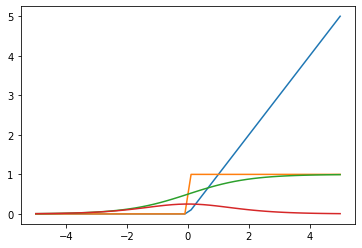

In [7]:

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def sigmoid_d(x):
    return sigmoid(x) * (1-sigmoid(x))
        
def relu(x):
    result =  x if x > 0 else 0
    return result

def relu_d(x):
    result = 1 if x >= 0 else 0
    return result

# Takes ints and np arrays from all dimensions
def callOnArray(x, function):    
    if (isinstance(x, np.ndarray)):
        if (x.ndim == 1):
            return np.array(list(map(function,x)))
        else:
            return np.array([callOnArray(ai, function) for ai in x]) # if it has multiple dimensions
    if isinstance(x, int):
        return function(x)

    
x = np.linspace(-5,5,50)
y= callOnArray(x, relu)
plt.plot(x,y)
y_d = callOnArray(x, relu_d)
plt.plot(x,y_d)
y_s= callOnArray(x, sigmoid)
plt.plot(x,y_s)
y_s_d = callOnArray(x, sigmoid_d)
plt.plot(x,y_s_d) 


#### Test how multiplications work with numpy

In [141]:
d_cost_d_a = np.array([[1,2,3],[1,2,4]]) # dc_da 
d_a_d_z = np.array([[1,2,3]])   # da_dz

d_cost_d_z = d_cost_d_a * d_a_d_z
x =  np.array([[1,1],[2,2],[3,3]])

d = np.array( [delta*p for n in d_cost_d_z for delta, p in zip(n,x) ])
d = np.sum(d.reshape(len(d_cost_d_a),len(x),len(x[0])), axis = 1) # aantal neurons (len(self.weights, aantal datapoints, aantal dimensies 
d

array([[36, 36],
       [45, 45]])

#### The building blocks for a neural net

In [247]:
class NeuralNet:
    def __init__(self, hidden = [5], input = 2, activationFunction = relu, activationFunctionD = relu_d):
#        layers = 
        self.activationFunction = activationFunction
        self.activationFunctionD = activationFunctionD
        self.weights = np.random.rand(hidden)*2 -1
        self.biases = np.random.rand(hiden)*2-1
    
class Layer:
    def __init__(self, input_size, neurons, learning_rate = 0.2, activationFunction = sigmoid, activationFunctionD = sigmoid_d):
        self.learning_rate = learning_rate
        self.input_size = input_size
        self.neurons = neurons
        self.weights = np.random.rand(neurons, input_size)*2 -1
        self.biases = np.array([np.random.rand(neurons)]).T *2 -1 # make the array in an array a column vector
        
        self.activationFunction = activationFunction
        self.activationFunctionD = activationFunctionD
        
    def calc(self, x):
        assert(len(x[0]) == self.weights.shape[1])         
        result = callOnArray(np.dot(self.weights, x.T) + self.biases, self.activationFunction)
        return result
    
    def cost(self, x, y):
        y_pred = self.calc(x)
        return (y_pred - y) * ( y_pred - y)
        
    
    def learn(self, x, y):
        assert(len(x)>0)
        y_pred = self.calc(x)
        d_cost_d_a = y_pred - y # delta cost over delta activation
        d_a_d_z = callOnArray(np.dot(self.weights, x.T) + self.biases, self.activationFunctionD)
                
        d_cost_d_z = -d_cost_d_a * d_a_d_z        
        
        d_w = np.array( [delta*p for n in d_cost_d_z for delta, p in zip(n,x) ])
        delta_weights = np.sum(d_w.reshape(self.neurons,len(x),len(x[0])), axis = 1) * self.learning_rate # aantal neurons (len(self.weights, aantal datapoints, aantal dimensies 
        
        delta_biases = np.sum(d_cost_d_z.reshape(self.neurons,len(x),1), axis = 1) * self.learning_rate
        
        #debugging:
#         print("delta w en b:")
#         print(delta_weights)
#         print(delta_biases)        
        
        self.weights += delta_weights
        self.biases  += delta_biases        
        return
    
    # For debugging purposes, prints weights and biases
    def show(self):
        string = ""
        biases = " "        
        for i in range(self.neurons):
            string +="[ "            
            for w in self.weights[i]:
                string+= "{0:4f} ".format(w)
                biases += "     "
            string += "]    "
            biases += "{0:4f}       ".format(self.biases[i][0])
        print(string)
        print(biases)    
        
        

#### Make a test setup

Everything above the diagonal is 1 (yellow) \
Everything below is 0

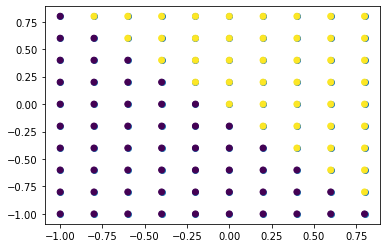

In [243]:
# perceptron = NeuralNet()
n = 10
X = np.zeros((n*n,2))
Y = np.zeros(n*n)
for i in range(n):
    for j in range(n):
        index = i*n + j
        X[index] = np.array([i * 0.2-1, j * 0.2 - 1])
        #Y[index] = X[index][0] + X[index][1] # output is simply y + x  #smooth transition instead of abrupt
        Y[index] = 1 if X[index][0] + X[index][1] >= 0 else 0 #output is 1 on the right side of the diagonal, 0 on th left side
plt.scatter(X[:,0], X[:,1])

X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.33, random_state=42)
# This is what a perfect classification looks like
plotresult2(X,Y)

#### Test the single layer

In [256]:
layer = Layer(2,1)

X_train2 = np.array([[1,1],[-1,-1]])
y_train2 = np.array([1,0])

# y_pred = layer.calc(X_train)[0]

train_cost = []
test_cost = []
for i in range(100):      
    cost= layer.cost(X_train, y_train)[0].mean()
    train_cost.append(cost)
    cost2= layer.cost(X_test, y_test)[0].mean()
    test_cost.append(cost2)
    y_pred = layer.calc(X_train)[0]
    #fig = plt.subplots()  
    #plotresult2(X_train, y_pred)
    layer.learn(X_train, y_train)
    


#### The training and test cost

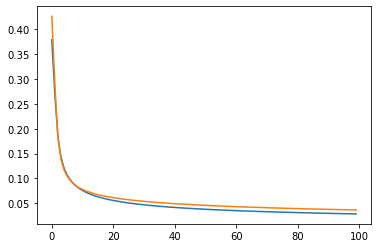

In [257]:
plt.plot(train_cost)
plt.plot(test_cost) # orange

#### Comparing sigmoid (previous) to relu 

In [258]:
layer = Layer(2,1, learning_rate = 0.1, activationFunction = relu, activationFunctionD = relu_d)

train_cost = []
test_cost = []
for i in range(100):      
    cost= layer.cost(X_train, y_train)[0].mean()
    train_cost.append(cost)
    cost2= layer.cost(X_test, y_test)[0].mean()
    test_cost.append(cost2)
    y_pred = layer.calc(X_train)[0]
    #fig = plt.subplots()  
    #plotresult2(X_train, y_pred)
    layer.learn(X_train, y_train)

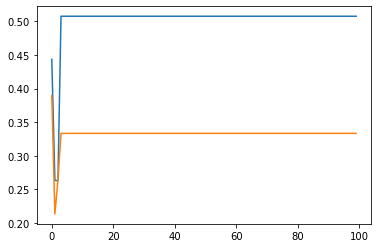

In [259]:
plt.plot(train_cost)
plt.plot(test_cost) # orange

Because the relu function and the derivative of the relu function are zero for x<0, it is possible for the algorithm to get stuck. If wx + b drops below 0 for all the training data, changes to the weights and biases become impossible and the algorithm no longer learns.

In [254]:
compare(layer.calc(X_train)[0], y_train)

0   =>   1.0
0   =>   1.0
0   =>   0.0
0   =>   1.0
0   =>   1.0
0   =>   0.0
0   =>   0.0
0   =>   1.0
0   =>   0.0
0   =>   0.0
0   =>   1.0
0   =>   0.0
0   =>   1.0
0   =>   0.0
0   =>   0.0
0   =>   0.0
0   =>   0.0
0   =>   0.0
0   =>   0.0
0   =>   0.0
0   =>   1.0
0   =>   0.0
0   =>   1.0
0   =>   0.0
0   =>   1.0
0   =>   0.0
0   =>   1.0
0   =>   1.0
0   =>   1.0
0   =>   0.0
0   =>   0.0
0   =>   0.0
0   =>   1.0
0   =>   1.0
0   =>   1.0
0   =>   0.0
0   =>   1.0
0   =>   1.0
0   =>   0.0
0   =>   1.0
0   =>   1.0
0   =>   1.0
0   =>   1.0
0   =>   1.0
0   =>   0.0
0   =>   1.0
0   =>   1.0
0   =>   0.0
0   =>   1.0
0   =>   1.0
0   =>   1.0
0   =>   0.0
0   =>   0.0
0   =>   0.0
0   =>   0.0
0   =>   0.0
0   =>   1.0
0   =>   1.0
0   =>   1.0
0   =>   1.0
0   =>   1.0
0   =>   0.0
0   =>   0.0
0   =>   0.0
0   =>   0.0
0   =>   1.0
0   =>   0.0
